In [248]:
# !pip install -U torchtext==0.17.2

In [249]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import build_vocab_from_iterator

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

seed = 42
torch.manual_seed(seed)

## Load Data and EDA

In [250]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [251]:
train = pd.read_csv('/content/drive/My Drive/code/Tweet/train.csv', encoding='latin-1')
test = pd.read_csv('/content/drive/My Drive/code/Tweet/test.csv', encoding='latin-1')

In [252]:
train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [253]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

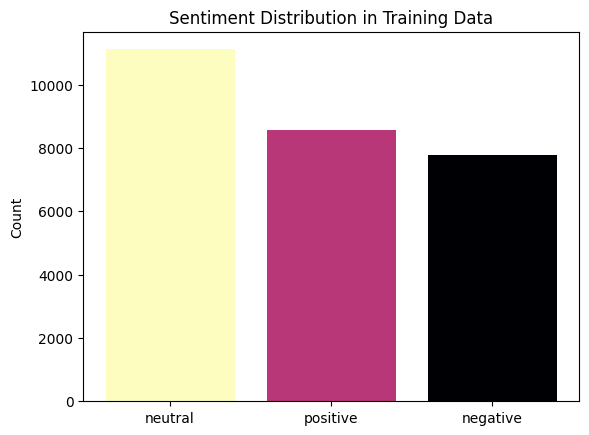

In [254]:
sentiment_counts = train['sentiment'].value_counts()

ranks = np.argsort(np.argsort(sentiment_counts.values))
colors = plt.cm.magma (ranks / max(ranks))

plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.ylabel("Count")
plt.title("Sentiment Distribution in Training Data")
plt.show()

Use only text and sentiment columns

In [255]:
col = ['text', 'sentiment']

train_df = train[col]
test_df = test[col]

## Prepare Sentiment Labels

In [256]:
sentiment_to_index = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
  }

train_df.loc[:, 'sentiment'] = train_df['sentiment'].map(sentiment_to_index)
test_df.loc[:, 'sentiment'] = test_df['sentiment'].map(sentiment_to_index)

## Prepare Text Data

### Remove Special Character

In [257]:
def remove_special_character(text):
    text=re.sub('<.*?>', ' ', text)
    text=re.sub('<.*>','',text)
    text=re.sub('http\S+|https\S+|www\S+','',text)
    text=re.sub('@\S+|#\S+','',text)
    text=re.sub('[^\w\s]','',text)
    return text

In [258]:
train_df.loc[:, 'text'] = train_df['text'].str.lower().str.strip().apply(remove_special_character)
test_df.loc[:, 'text'] = test_df['text'].str.lower().str.strip().apply(remove_special_character)

In [259]:
train_df.head()

,text,sentiment
0,id have responded if i were going,1
1,sooo sad i will miss you here in san diego,0
2,my boss is bullying me,0
3,what interview leave me alone,0
4,sons of why couldnt they put them on the rele...,0


### Tokenize

In [260]:
train_text = []
train_data = []
test_data = []

for _, row in train_df.iterrows():
    text = row["text"]
    tokens = word_tokenize(text)
    train_text.append((tokens))
    train_data.append([row["sentiment"], tokens])

In [261]:
train_text[:3]

[['id', 'have', 'responded', 'if', 'i', 'were', 'going'],
 ['sooo', 'sad', 'i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego'],
 ['my', 'boss', 'is', 'bullying', 'me']]

In [262]:
train_data[:3]

[[1, ['id', 'have', 'responded', 'if', 'i', 'were', 'going']],
 [0,
  ['sooo', 'sad', 'i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego']],
 [0, ['my', 'boss', 'is', 'bullying', 'me']]]

### Build Vocabulary (Word-to-Index Mapping)

In [263]:
def yield_tokens(data):
    for d in data:
        yield d[1]

vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"]) # adds a special token <unk> (for unknown words).
vocab.set_default_index(index=vocab["<unk>"]) # unknown words (words not in vocab) get mapped to <unk> (index 0).

### Encode text

In [264]:
encoded_train = [[label, vocab(tokens)] for label, tokens in train_data]
encoded_train[:3]

[[1, [290, 16, 23316, 68, 1, 120, 46]],
 [0, [414, 116, 1, 58, 89, 7, 88, 10, 1510, 2257]],
 [0, [5, 1298, 9, 13633, 15]]]

In [265]:
for _, row in test.iterrows():
    text = row["text"]
    tokens = word_tokenize(text)
    test_data.append([0, vocab(tokens)]) # Match the format expected by the model

### Batch Collation

In [266]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(_label)
         processed_text = torch.tensor(_text, dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0)) # Stores sequence length in offsets to track where each sample starts

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0) # Store cumulative sequence positions.
    text_list = torch.cat(text_list)

    return label_list.to(device), text_list.to(device), offsets.to(device)

In [267]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

False


### Create PyTorch DataLoader

In [268]:
batch_size = 128
num_class = 3

train_data, val_data = train_test_split(encoded_train, test_size=0.05, shuffle=True)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, collate_fn=collate_batch)

## Data Prediction

### Initialize Model

In [269]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        dropout = self.dropout(embedded)
        return self.fc(dropout)

model = TextClassificationModel(len(vocab), embed_dim=50, num_class=3).to(device)

In [270]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training and Validation Loop

In [271]:
def train_and_validate_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, patience, device):
    min_val_loss = float('inf')
    count = 0
    best_model_state = None

    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    for epoch in range(1, num_epochs+1):
        model.train()
        training_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training phase
        for idx, (labels, text, offsets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(text, offsets)
            loss = criterion(outputs, labels).mean()
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        epoch_train_loss = training_loss / len(train_loader)
        epoch_train_acc = correct_train / total_train
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)

        # Validation phase
        model.eval()
        validation_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for idx, (labels, text, offsets) in enumerate(val_loader):
                outputs = model(text, offsets)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = validation_loss / len(val_loader)
        epoch_val_acc = correct_val / total_val
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # Early stopping
        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            count = 0
            best_epoch = epoch
            best_model_state = model.state_dict()
        else:
            count += 1
            if count >= patience:
                print(f"Early stopping triggered at epoch {epoch}. Best Val Loss: {min_val_loss:.4f} at Epoch {best_epoch}/{num_epochs}")
                break

    return best_model_state, train_loss, val_loss

In [272]:
best_model_state, train_loss, val_loss = train_and_validate_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=20,
    patience=10,
    device=device
)

Epoch 1/20 - Train Loss: 1.0617, Train Acc: 0.4237 | Val Loss: 1.0080 | Val Acc: 0.5146
Epoch 2/20 - Train Loss: 0.9657, Train Acc: 0.5334 | Val Loss: 0.9239, Val Acc: 0.5786
Epoch 3/20 - Train Loss: 0.8827, Train Acc: 0.5961 | Val Loss: 0.8613, Val Acc: 0.6048
Epoch 4/20 - Train Loss: 0.8135, Train Acc: 0.6362 | Val Loss: 0.8187, Val Acc: 0.6230
Epoch 5/20 - Train Loss: 0.7560, Train Acc: 0.6725 | Val Loss: 0.7915, Val Acc: 0.6426
Epoch 6/20 - Train Loss: 0.7107, Train Acc: 0.7046 | Val Loss: 0.7734, Val Acc: 0.6565
Epoch 7/20 - Train Loss: 0.6706, Train Acc: 0.7237 | Val Loss: 0.7624, Val Acc: 0.6623
Epoch 8/20 - Train Loss: 0.6382, Train Acc: 0.7410 | Val Loss: 0.7560, Val Acc: 0.6696
Epoch 9/20 - Train Loss: 0.6031, Train Acc: 0.7593 | Val Loss: 0.7541, Val Acc: 0.6747
Epoch 10/20 - Train Loss: 0.5771, Train Acc: 0.7732 | Val Loss: 0.7546, Val Acc: 0.6703
Epoch 11/20 - Train Loss: 0.5555, Train Acc: 0.7841 | Val Loss: 0.7578, Val Acc: 0.6761
Epoch 12/20 - Train Loss: 0.5295, Train 

In [280]:
if best_model_state:
    model.load_state_dict(best_model_state)

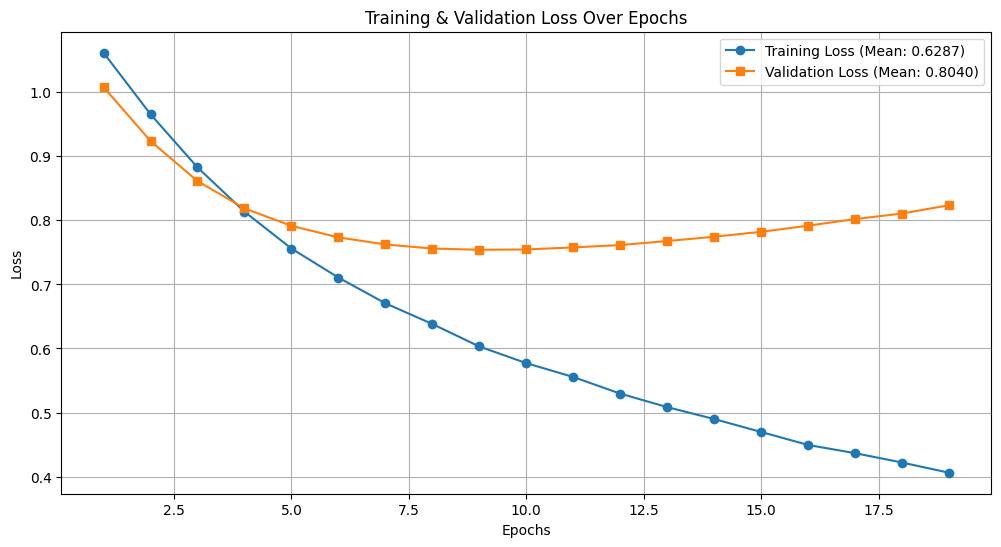

In [281]:
mean_train_loss = sum(train_loss) / len(train_loss)
mean_val_loss = sum(val_loss) / len(val_loss)

range_epoch = len(train_loss)

# Plot the Loss Curve
plt.figure(figsize=(12, 6))
plt.plot(range(1, range_epoch + 1), train_loss, label=f'Training Loss (Mean: {mean_train_loss:.4f})', marker='o')
plt.plot(range(1, range_epoch + 1), val_loss, label=f'Validation Loss (Mean: {mean_val_loss:.4f})', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

### Testing Loop

In [275]:
import csv

model.eval()

with torch.no_grad(), open('predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'predicted'])

    for idx, (label, text, offsets) in enumerate(test_loader):
        outputs = model(text, offsets)
        predicted = outputs.argmax(dim=1).item()
        writer.writerow([idx, predicted])

In [276]:
test_pred = pd.read_csv('/content/predictions.csv')

In [277]:
test_results = pd.concat([test_df.reset_index(drop=True), test_pred], axis=1)
test_results.head(10)

,text,sentiment,id,predicted
0,last session of the day,1,0,1
1,shanghai is also really exciting precisely sk...,2,1,2
2,recession hit veronique branquinho she has to ...,0,2,0
3,happy bday,2,3,2
4,i like it,2,4,2
5,thats great weee visitors,2,5,2
6,i think everyone hates me on here lol,0,6,1
7,soooooo wish i could but im in school and mysp...,0,7,0
8,and within a short time of the last clue all o...,1,8,2
9,what did you get my day is alright havent don...,1,9,1


### Evaluation

In [282]:
class_names = ["Negative", "Neutral", "Positive"]
true = test_results['sentiment'].astype(int)
pred = test_results['predicted'].astype(int)

report = classification_report(true, pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    Negative       0.70      0.48      0.57      1001
     Neutral       0.54      0.77      0.64      1430
    Positive       0.76      0.54      0.63      1103

    accuracy                           0.62      3534
   macro avg       0.67      0.60      0.61      3534
weighted avg       0.65      0.62      0.62      3534



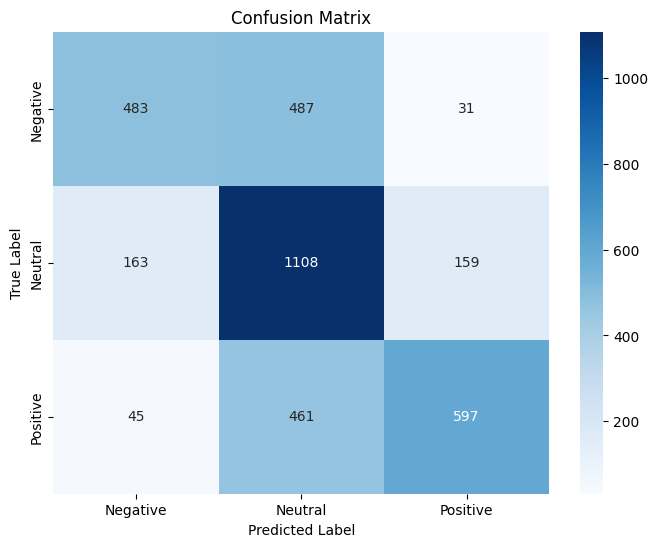

In [283]:
cm = confusion_matrix(true, pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()